In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [ ]:
onion_feat_path = "/Users/rashidkarimov/Desktop/agro/data/processed/analysis/statistics_committee/onion_prod_features.csv"
potato_feat_path = "/Users/rashidkarimov/Desktop/agro/data/processed/analysis/statistics_committee/potato_prod_features.csv"

onion_df = pd.read_csv(onion_feat_path)
potato_df = pd.read_csv(potato_feat_path)

onion_df['Crop'] = 'Onion'
potato_df['Crop'] = 'Potato'

df = pd.concat([onion_df, potato_df], ignore_index=True)
df = df[df['Setting'] != "Republic of Azerbaijan"]  # Exclude aggregate if present
df.dropna(subset=['Setting','year','first5_sum','last5_sum','growth','std_dev','cagr'], inplace=True)
df.head()

df.head()


,Setting,year,onion_prod,first5_sum,last5_sum,growth,std_dev,cagr,Crop,potato_prod
1,Baku city,2000,69.0,409.0,185.0,-224.0,162.512937,-0.022899,Onion,NaN
2,Nakhchivan Autonomous Republic,2000,2155.0,19077.0,29686.4,10609.4,1034.052377,0.049371,Onion,NaN
4,Babak district,2000,284.0,6634.0,1995.1,-4638.9,714.480159,-0.099955,Onion,NaN
5,Julfa district,2000,350.0,2096.0,1597.3,-498.7,229.280424,-0.084450,Onion,NaN
7,Ordubad district,2000,150.0,1443.0,2365.2,922.2,155.260242,-0.124753,Onion,NaN


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 3336 entries, 1 to 4175
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Setting      3336 non-null   object 
 1   year         3336 non-null   int64  
 2   onion_prod   1617 non-null   float64
 3   first5_sum   3336 non-null   float64
 4   last5_sum    3336 non-null   float64
 5   growth       3336 non-null   float64
 6   std_dev      3336 non-null   float64
 7   cagr         3336 non-null   float64
 8   Crop         3336 non-null   object 
 9   potato_prod  1684 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 286.7+ KB


,year,onion_prod,first5_sum,last5_sum,growth,std_dev,cagr,potato_prod
count,3336.000000,1617.000000,3.336000e+03,3.336000e+03,3336.000000,3336.000000,3336.000000,1684.000000
mean,2011.500000,5658.813482,5.898284e+04,9.466953e+04,35686.687050,4998.449499,0.020938,26137.779394
std,6.923224,13587.341589,2.020365e+05,2.803595e+05,109678.926736,12170.271739,0.062170,70290.543412
min,2000.000000,1.000000,1.600000e+01,1.336000e+02,-81004.800000,24.015886,-0.124753,0.200000
25%,2005.750000,394.600000,3.924000e+03,3.171900e+03,-2863.700000,451.096284,-0.019011,2244.500000
50%,2011.500000,1639.000000,1.152100e+04,1.430270e+04,1635.500000,1366.660447,0.021665,5956.000000
75%,2017.250000,4071.000000,3.163500e+04,5.212270e+04,19321.900000,3237.870559,0.054051,14896.250000
max,2023.000000,173060.900000,1.985972e+06,2.591964e+06,605992.400000,94512.306423,0.226176,677107.000000


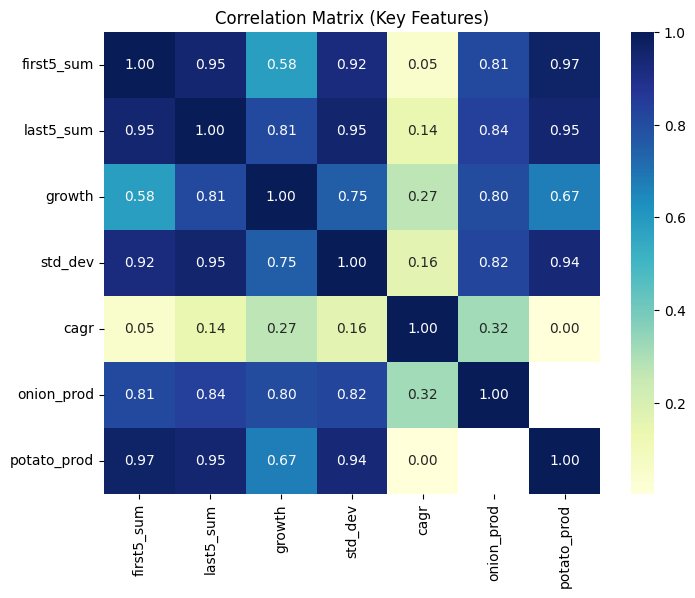

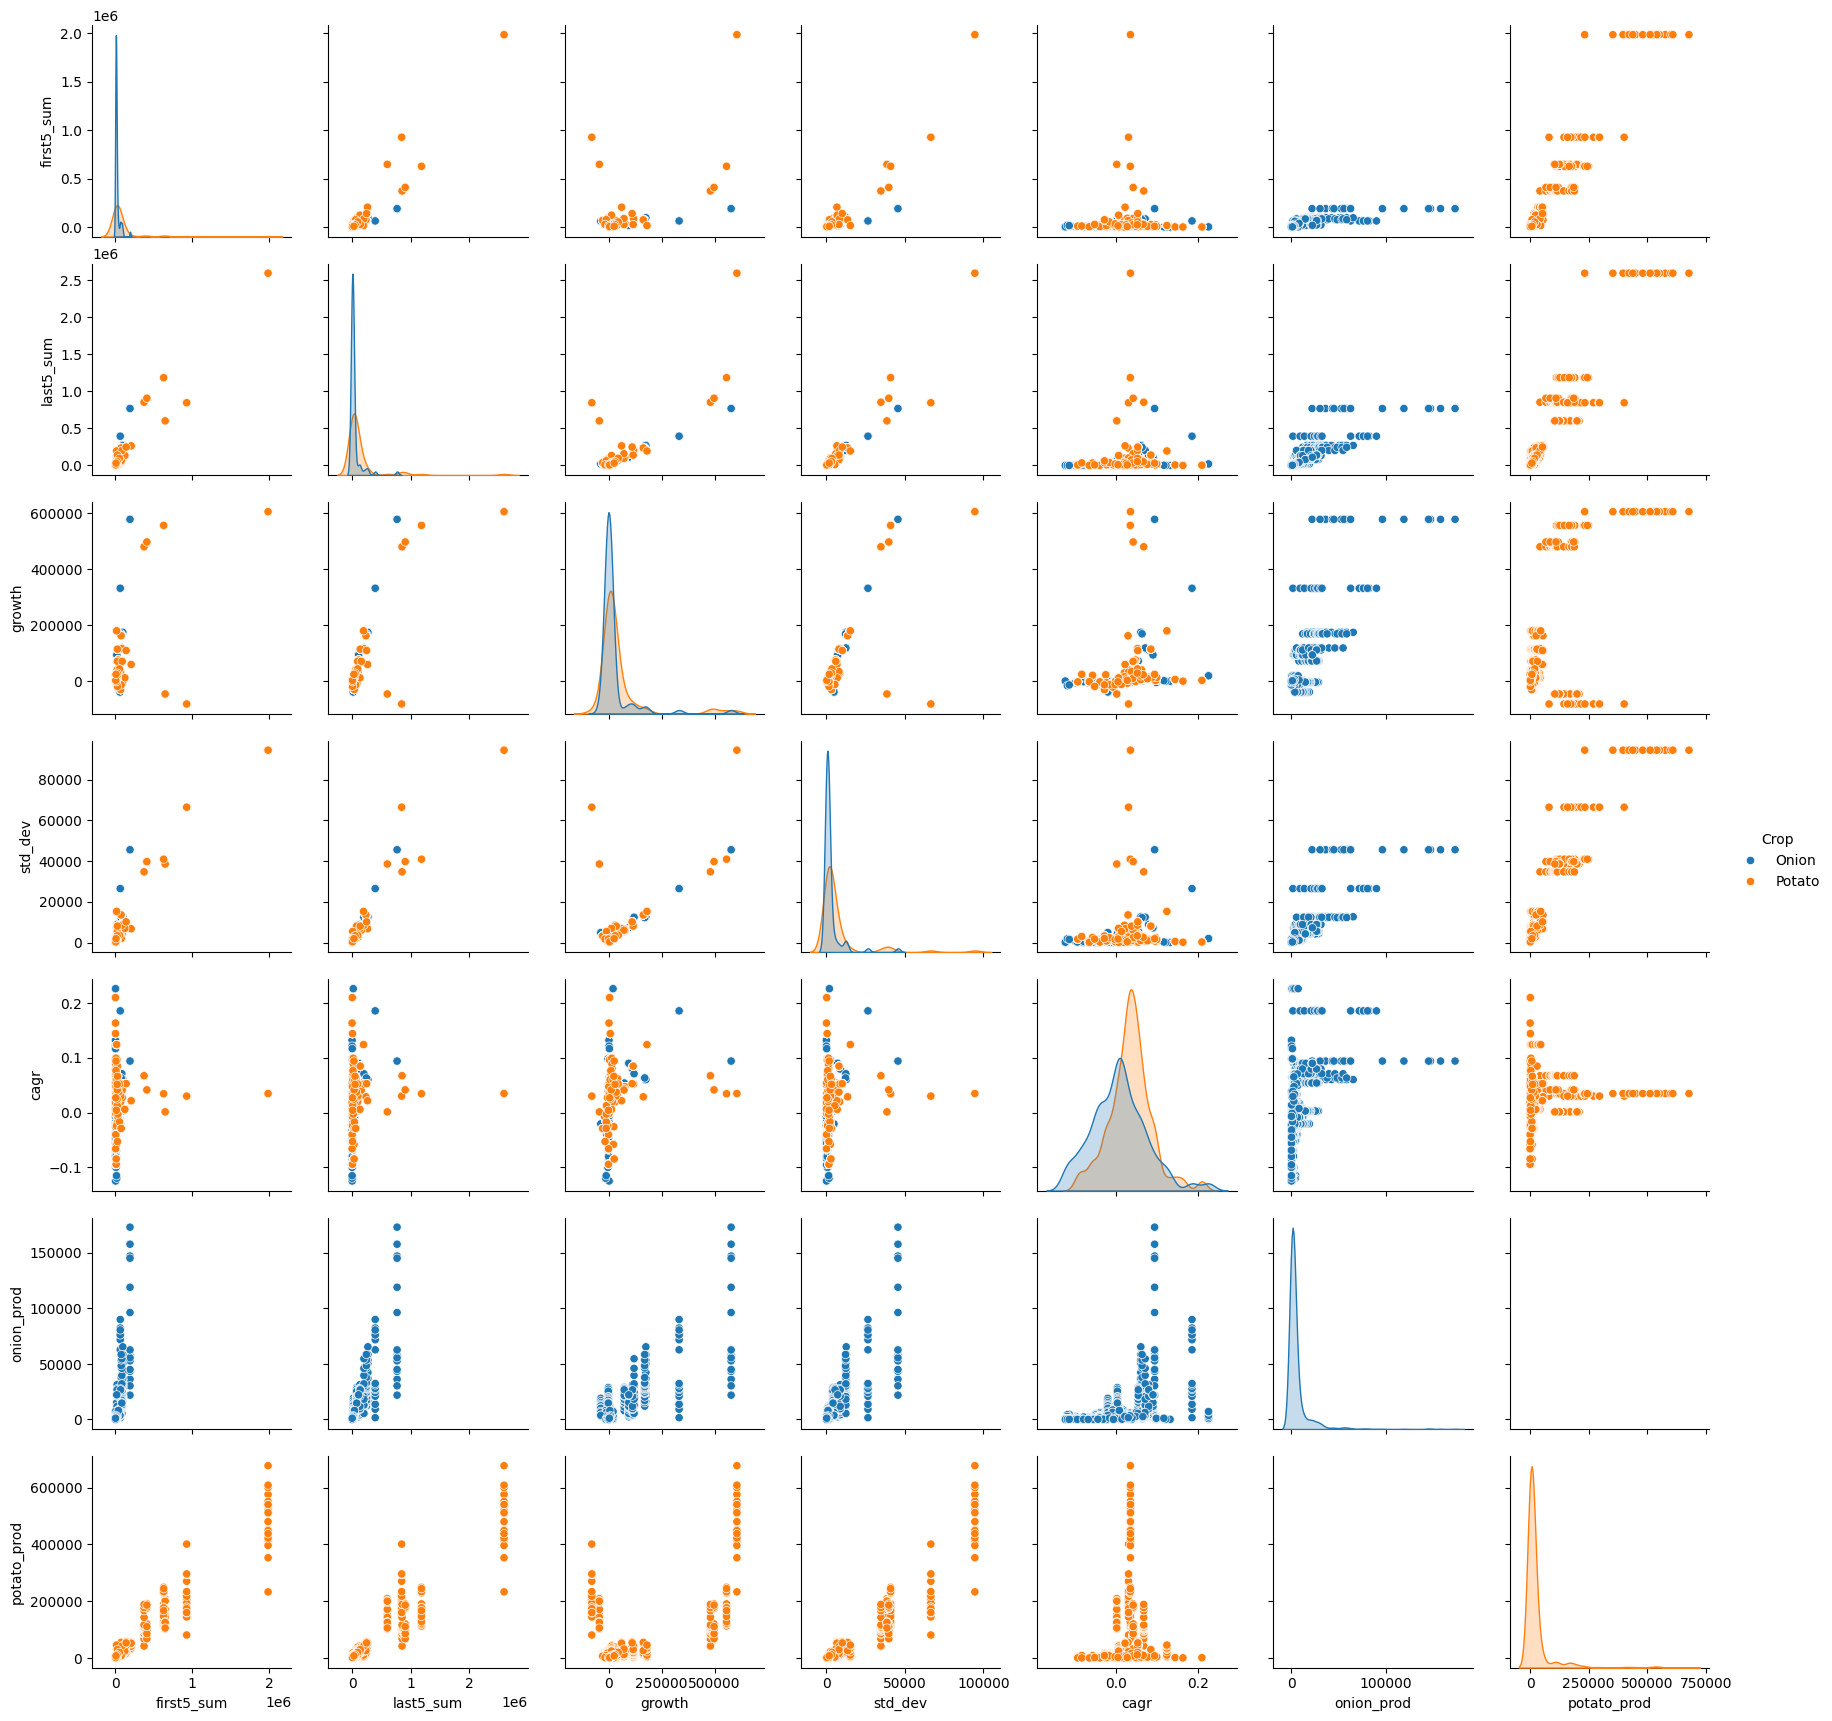

In [8]:
num_cols = ['first5_sum','last5_sum','growth','std_dev','cagr']
if 'onion_prod' in df.columns:
    num_cols.append('onion_prod')
if 'potato_prod' in df.columns:
    num_cols.append('potato_prod')
if 'yoy_growth' in df.columns:
    num_cols.append('yoy_growth')

corr = df[num_cols].corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Correlation Matrix (Key Features)")
plt.show()

sns.pairplot(df[num_cols + ['Crop']], hue='Crop')
plt.show()


/var/folders/rd/v7chfg_s48s67l7bpbm9w9180000gn/T/ipykernel_1088/1567017810.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


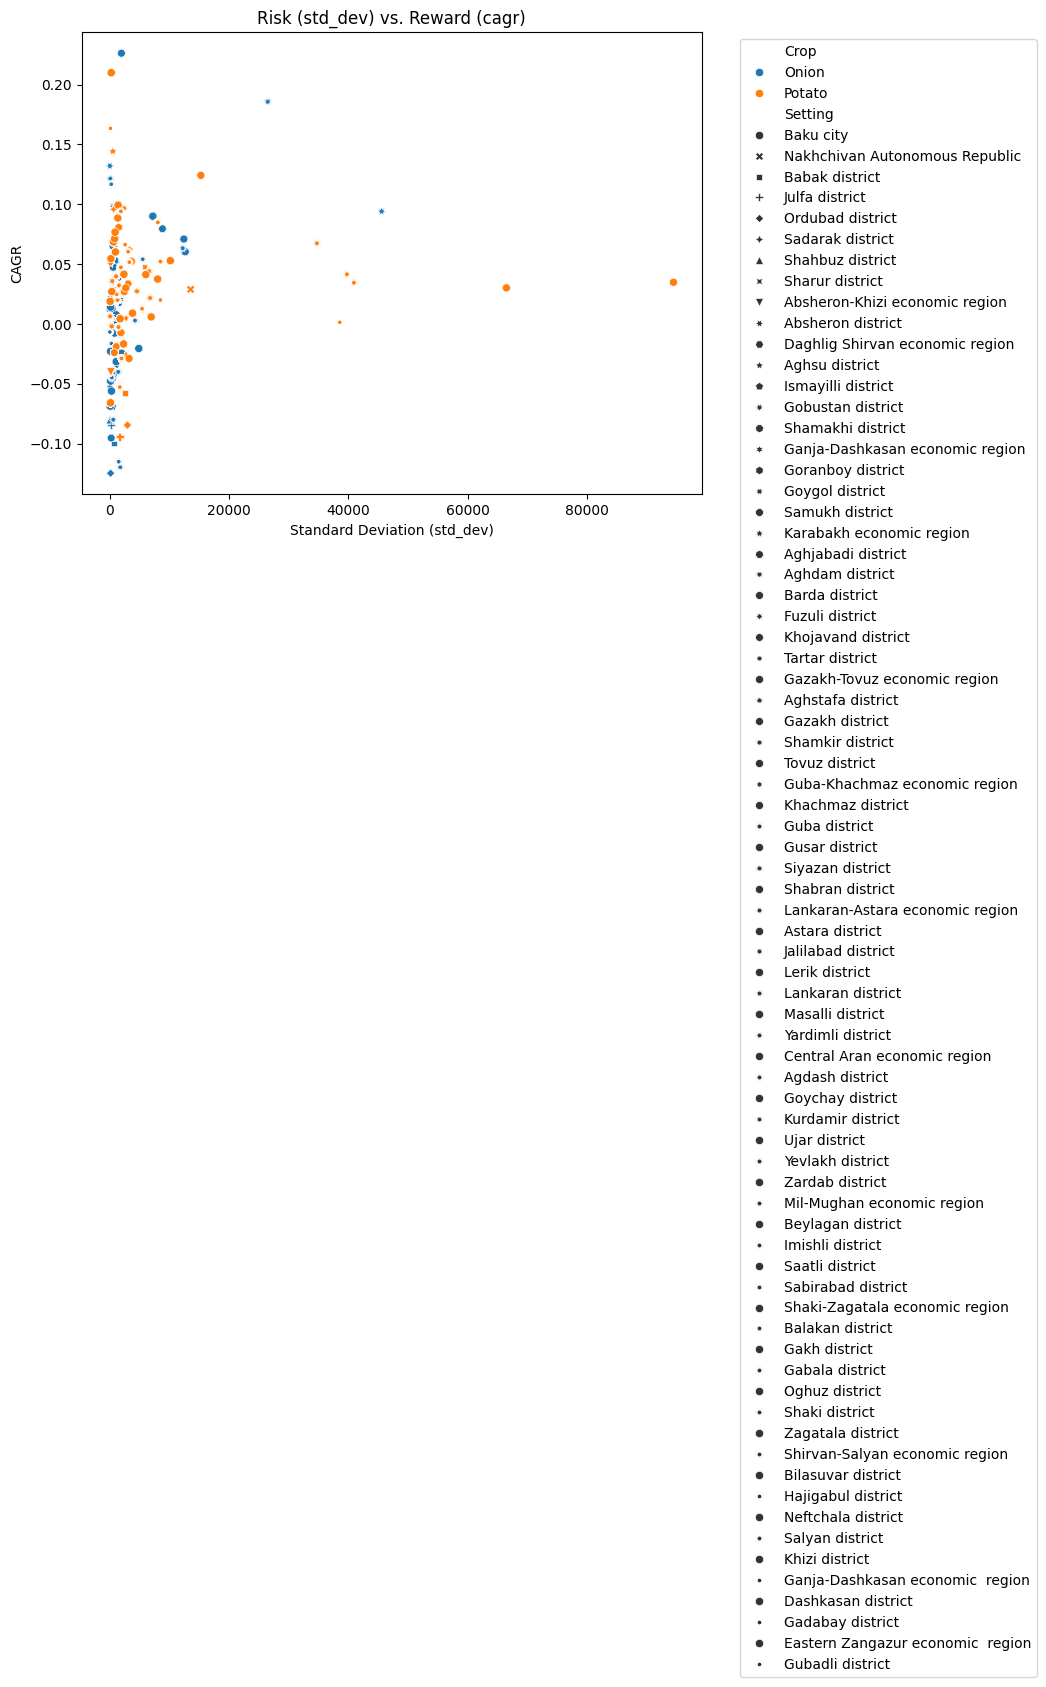

In [9]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, 
    x='std_dev', 
    y='cagr', 
    hue='Crop',
    style='Setting'
)
plt.title("Risk (std_dev) vs. Reward (cagr)")
plt.xlabel("Standard Deviation (std_dev)")
plt.ylabel("CAGR")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


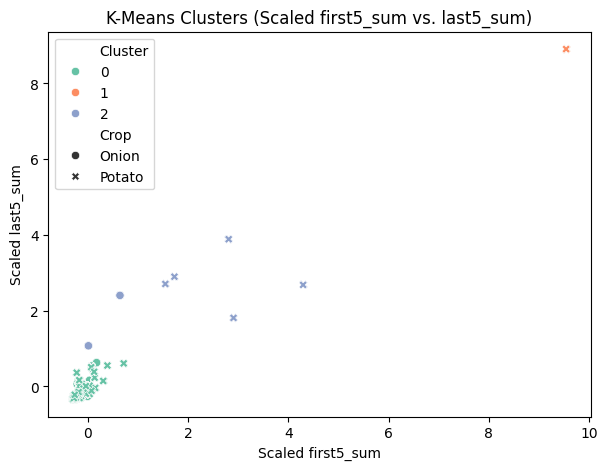

,first5_sum,last5_sum,growth,std_dev,cagr
Cluster,,,,,
0,2.274601e+04,3.827594e+04,15529.931298,2348.697765,0.018482
1,1.985972e+06,2.591964e+06,605992.400000,94512.306423,0.034828
2,4.618451e+05,7.932789e+05,331433.728571,41798.966680,0.064926


In [10]:
# K-Means Clustering on a subset of numeric features
features = ['first5_sum','last5_sum','growth','std_dev','cagr']
X = df[features].copy()
X.fillna(0, inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=X_scaled[:,0], 
    y=X_scaled[:,1], 
    hue=df['Cluster'], 
    style=df['Crop'], 
    palette='Set2'
)
plt.title("K-Means Clusters (Scaled first5_sum vs. last5_sum)")
plt.xlabel("Scaled first5_sum")
plt.ylabel("Scaled last5_sum")
plt.show()

df.groupby('Cluster')[features].mean()


In [ ]:
target_col = 'growth'
if 'yoy_growth' in df.columns:
    target_col = 'yoy_growth'

model_features = ['first5_sum','last5_sum','std_dev','cagr']
X_train, X_test, y_train, y_test = train_test_split(
    df[model_features], 
    df[target_col], 
    test_size=0.2, 
    random_state=42
)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

coef_df = pd.DataFrame({'Feature': model_features, 'Coefficient': lr.coef_})
print("Intercept:", lr.intercept_)
print(coef_df)

mae = np.mean(np.abs(y_pred - y_test))
r2 = lr.score(X_test, y_test)
print(f"MAE: {mae:.2f}, R^2: {r2:.2f}")


Intercept: 7.275957614183426e-11
      Feature   Coefficient
0  first5_sum -1.000000e+00
1   last5_sum  1.000000e+00
2     std_dev -1.887379e-15
3        cagr -3.958141e-12
MAE: 0.00, R^2: 1.00


Top 5 Regions by Average Growth per Crop:
                             Setting    Crop    growth
46      Gazakh-Tovuz economic region  Potato  605992.4
71          Karabakh economic region   Onion  578624.6
82   Lankaran-Astara economic region  Potato  556984.5
68                Jalilabad district  Potato  497708.0
118                 Shamkir district  Potato  480584.8
6                    Aghdam district   Onion  332407.3
44                   Gazakh district  Potato  180256.7
45      Gazakh-Tovuz economic region   Onion  175004.4
117                 Shamkir district   Onion  169532.2
22                    Barda district   Onion  119053.0


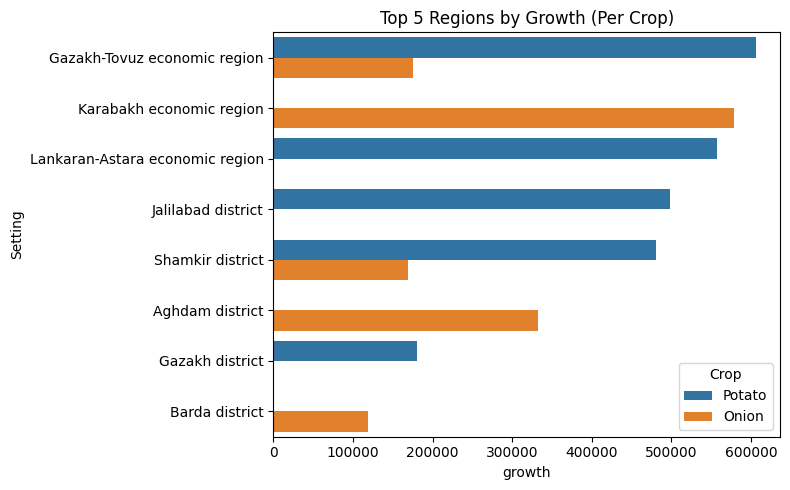

In [12]:
metric_col = 'growth'
if 'yoy_growth' in df.columns:
    metric_col = 'yoy_growth'

top5 = (
    df.groupby(['Setting','Crop'])[metric_col]
      .mean()
      .reset_index()
      .sort_values(metric_col, ascending=False)
      .groupby('Crop')
      .head(5)
)

print("Top 5 Regions by Average", metric_col.capitalize(), "per Crop:")
print(top5)

plt.figure(figsize=(8,5))
sns.barplot(data=top5, x=metric_col, y='Setting', hue='Crop')
plt.title(f"Top 5 Regions by {metric_col.capitalize()} (Per Crop)")
plt.tight_layout()
plt.show()
